### Imports and Definitions from Draco 2

In [3]:
[item for item in [1,2] if item not in [1,0]]

[2]

In [34]:
# Display utilities
import json

import numpy as np
from IPython.display import Markdown, display


# Handles serialization of common numpy datatypes
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


def md(markdown: str):
    display(Markdown(markdown))


def pprint(obj):
    md(f"```json\n{json.dumps(obj, indent=2, cls=NpEncoder)}\n```")

In [13]:
import altair as alt
import pandas as pd
from vega_datasets import data as vega_data
from draco.renderer import AltairRenderer

import draco as drc

# Loading data to be explored
df: pd.DataFrame = vega_data.seattle_weather()
df.head()

date  precipitation  temp_max  temp_min  wind  weather
0 2012-01-01            0.0      12.8       5.0   4.7  drizzle
1 2012-01-02           10.9      10.6       2.8   4.5     rain
2 2012-01-03            0.8      11.7       7.2   2.3     rain
3 2012-01-04           20.3      12.2       5.6   4.7     rain
4 2012-01-05            1.3       8.9       2.8   6.1     rain

In [14]:
import itertools

def generate_column_combinations(df):
    # Get the list of columns from the dataframe
    columns = df.columns.tolist()
    
    # Generate all unique combinations of two columns
    combinations = list(itertools.combinations(columns, 2))
    
    # Convert each combination to a list format
    combinations = [list(comb) for comb in combinations]
    
    return combinations


combinations = generate_column_combinations(df)

# Print the unique combinations
print(combinations)


[['date', 'precipitation'], ['date', 'temp_max'], ['date', 'temp_min'], ['date', 'wind'], ['date', 'weather'], ['precipitation', 'temp_max'], ['precipitation', 'temp_min'], ['precipitation', 'wind'], ['precipitation', 'weather'], ['temp_max', 'temp_min'], ['temp_max', 'wind'], ['temp_max', 'weather'], ['temp_min', 'wind'], ['temp_min', 'weather'], ['wind', 'weather']]


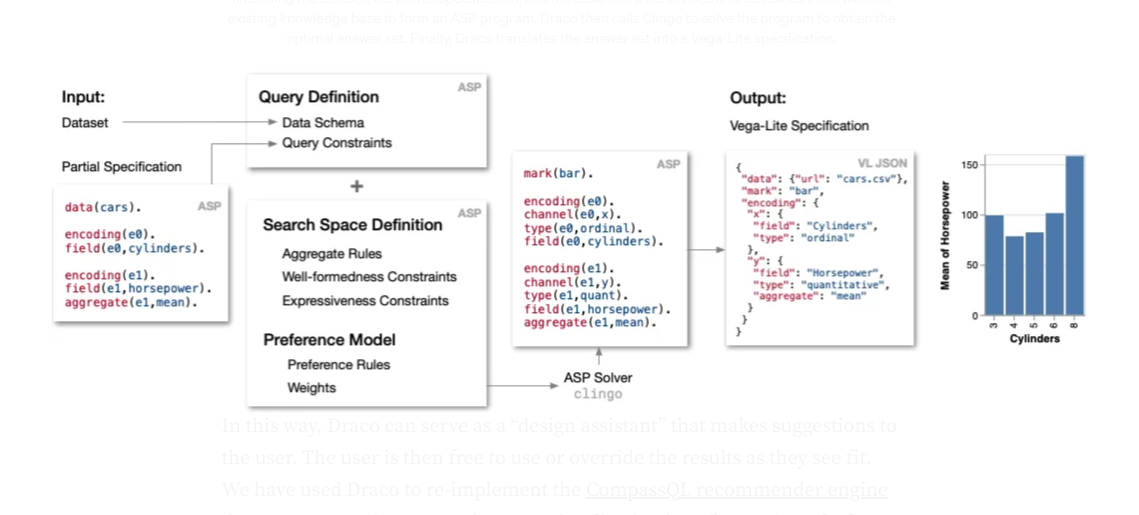

### Data Schema -> Draco Facts from Data

In [36]:
# At the beginning we extract the schema of the data that we have
data_schema = drc.schema_from_dataframe(df)
# pprint(data_schema)

# Now we can convert this schema to the facts that Draco can use later to reason about the data when generating recommendations
data_schema_facts = drc.dict_to_facts(data_schema)
# pprint(data_schema_facts)

### Partial Specification

In [37]:
input_spec_base = data_schema_facts + [
    "entity(view,root,v0).",
    "entity(mark,v0,m0).",
]
d = drc.Draco()
renderer = AltairRenderer()

In [38]:
def recommend_charts(
    spec: list[str], draco: drc.Draco, num: int = 5, labeler=lambda i: f"CHART {i+1}"
) -> dict[str, tuple[list[str], dict]]:
    # Dictionary to store the generated recommendations, keyed by chart name
    chart_specs = {}
    for i, model in enumerate(draco.complete_spec(spec, num)):
        chart_name = labeler(i)
        spec = drc.answer_set_to_dict(model.answer_set)

        # print(chart_name)
        # print(f"COST: {model.cost}")
        chart = renderer.render(spec=spec, data=df)
        # Adjust column-faceted chart size
        if (
            isinstance(chart, alt.FacetChart)
            and chart.facet.column is not alt.Undefined
        ):
            chart = chart.configure_view(continuousWidth=130, continuousHeight=130)
        print(model.cost[0])
        display(chart)

        chart_specs[chart_name] = drc.dict_to_facts(spec), spec, model.cost[0], chart

    return chart_specs

### Recommend Visualizations from Partial Specifications

In [39]:
input_spec = input_spec_base
initial_recommendations = recommend_charts(spec=input_spec, draco=d)

3


alt.Chart(...)

4


alt.Chart(...)

4


alt.FacetChart(...)

4


alt.Chart(...)

5


alt.FacetChart(...)

In [31]:
initial_recommendations

{'CHART 1': (['attribute(number_rows,root,1461).',
   'attribute(task,root,summary).',
   'entity(field,root,0).',
   'attribute((field,name),0,date).',
   'attribute((field,type),0,datetime).',
   'attribute((field,unique),0,1461).',
   'attribute((field,entropy),0,7287).',
   'entity(field,root,1).',
   'attribute((field,name),1,precipitation).',
   'attribute((field,type),1,number).',
   'attribute((field,unique),1,111).',
   'attribute((field,entropy),1,2422).',
   'attribute((field,min),1,0).',
   'attribute((field,max),1,55).',
   'attribute((field,std),1,6).',
   'entity(field,root,2).',
   'attribute((field,name),2,temp_max).',
   'attribute((field,type),2,number).',
   'attribute((field,unique),2,67).',
   'attribute((field,entropy),2,3934).',
   'attribute((field,min),2,-1).',
   'attribute((field,max),2,35).',
   'attribute((field,std),2,7).',
   'entity(field,root,3).',
   'attribute((field,name),3,temp_min).',
   'attribute((field,type),3,number).',
   'attribute((field,un

### Extend Partial Input Specification 

In [32]:
input_spec = input_spec_base + [
    # We want to encode the `date` field
    "entity(encoding,m0,e0).",
    "attribute((encoding,field),e0,date).",
    # We want to encode the `temp_max` field
    "entity(encoding,m0,e1).",
    "attribute((encoding,field),e1,temp_max).",
    # # We want the chart to be a faceted chart
    # "entity(facet,v0,f0).",
    # "attribute((facet,channel),f0,col).",
]
recommendations = recommend_charts(spec=input_spec, draco=d, num=5)

14


alt.Chart(...)

14


alt.Chart(...)

14


alt.Chart(...)

14


alt.Chart(...)

15


alt.Chart(...)

In [14]:
display(recommendations['CHART 1'][0])

['attribute(number_rows,root,1461).',
 'attribute(task,root,summary).',
 'entity(field,root,0).',
 'attribute((field,name),0,date).',
 'attribute((field,type),0,datetime).',
 'attribute((field,unique),0,1461).',
 'attribute((field,entropy),0,7287).',
 'entity(field,root,1).',
 'attribute((field,name),1,precipitation).',
 'attribute((field,type),1,number).',
 'attribute((field,unique),1,111).',
 'attribute((field,entropy),1,2422).',
 'attribute((field,min),1,0).',
 'attribute((field,max),1,55).',
 'attribute((field,std),1,6).',
 'entity(field,root,2).',
 'attribute((field,name),2,temp_max).',
 'attribute((field,type),2,number).',
 'attribute((field,unique),2,67).',
 'attribute((field,entropy),2,3934).',
 'attribute((field,min),2,-1).',
 'attribute((field,max),2,35).',
 'attribute((field,std),2,7).',
 'entity(field,root,3).',
 'attribute((field,name),3,temp_min).',
 'attribute((field,type),3,number).',
 'attribute((field,unique),3,55).',
 'attribute((field,entropy),3,3596).',
 'attribute

### Generating Input Specifications Programmatically

In [ ]:
def rec_from_generated_spec(
    marks: list[str],
    fields: list[str],
    encoding_channels: list[str],
    draco: drc.Draco,
    num: int = 1,
) -> dict[str, dict]:
    input_specs = [
        (
            (mark, field, enc_ch),
            input_spec_base
            + [
                f"attribute((mark,type),m0,{mark}).",
                "entity(encoding,m0,e0).",
                f"attribute((encoding,field),e0,{field}).",
                f"attribute((encoding,channel),e0,{enc_ch}).",
                # filter out designs with less than 2 encodings
                ":- {entity(encoding,_,_)} < 2.",
                # exclude multi-layer designs
                ":- {entity(mark,_,_)} != 1.",
            ],
        )
        for mark in marks
        for field in fields
        for enc_ch in encoding_channels
    ]
    recs = {}
    for cfg, spec in input_specs:

        def labeler(i):
            f"CHART {i + 1} ({' | '.join(cfg)})"

        recs = recs | recommend_charts(spec=spec, draco=draco, num=num, labeler=labeler)
        
    return recs

In [17]:
recommendations = rec_from_generated_spec(
    marks=["point", "bar", "line", "rect"],
    fields=["temp_min", "date"],
    encoding_channels=["color", "shape", "size"],
    draco=d,
)

None
COST: [27]


alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.FacetChart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.FacetChart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

### Try Evaluation

In [22]:
def draco_with_updated_kb(pref_weight: int) -> drc.Draco:
    # Custom soft constraint to discourage faceting with rect mark and color encoding
    rect_color_facet_pref = """
    % @soft(rect_color_facet) Faceting with rect mark and color encoding.
    preference(rect_color_facet,Fa) :-
        attribute((mark,type),_,rect),
        attribute((encoding,channel),_,color),
        attribute((facet,channel),Fa,_).
    """.strip()
    rect_color_facet_pref_weight = pref_weight

    # Update the default soft constraint knowledge base (program)
    soft_updated = drc.Draco().soft + f"\n\n{rect_color_facet_pref}\n\n"
    # Assign the weight to the new soft constraint
    weights_updated = drc.Draco().weights | {
        "rect_color_facet_weight": rect_color_facet_pref_weight
    }
    return drc.Draco(soft=soft_updated, weights=weights_updated)

In [24]:
weight = 0
display(Markdown(f"**Weight for `rect_color_facet` preference: {weight}**"))
updated_draco = draco_with_updated_kb(pref_weight=weight)
recommendations = rec_from_generated_spec(
    marks=["rect"],
    fields=["weather", "date"],
    encoding_channels=["color"],
    draco=updated_draco,
)
# display_debug_data(draco=updated_draco, specs=recommendations)

**Weight for `rect_color_facet` preference: 0**

None
COST: [69]


alt.FacetChart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.FacetChart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

In [23]:
weight = 10
display(Markdown(f"**Weight for `rect_color_facet` preference: {weight}**"))
updated_draco = draco_with_updated_kb(pref_weight=weight)
recommendations = rec_from_generated_spec(
    marks=["rect"],
    fields=["weather", "date"],
    encoding_channels=["color"],
    draco=updated_draco,
)
# display_debug_data(draco=updated_draco, specs=recommendations)

**Weight for `rect_color_facet` preference: 10**

None
COST: [72]


alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

alt.Chart(...)

{None: (['attribute(number_rows,root,1461).', 'attribute(task,root,summary).', 'entity(field,root,0).', 'attribute((field,name),0,date).', 'attribute((field,type),0,datetime).', 'attribute((field,unique),0,1461).', 'attribute((field,entropy),0,7287).', 'entity(field,root,1).', 'attribute((field,name),1,precipitation).', 'attribute((field,type),1,number).', 'attribute((field,unique),1,111).', 'attribute((field,entropy),1,2422).', 'attribute((field,min),1,0).', 'attribute((field,max),1,55).', 'attribute((field,std),1,6).', 'entity(field,root,2).', 'attribute((field,name),2,temp_max).', 'attribute((field,type),2,number).', 'attribute((field,unique),2,67).', 'attribute((field,entropy),2,3934).', 'attribute((field,min),2,-1).', 'attribute((field,max),2,35).', 'attribute((field,std),2,7).', 'entity(field,root,3).', 'attribute((field,name),3,temp_min).', 'attribute((field,type),3,number).', 'attribute((field,unique),3,55).', 'attribute((field,entropy),3,3596).', 'attribute((field,min),3,-7).'

## Convertion of charts

In [1]:
import vl_convert as vlc

# Vega-Lite specification as JSON string
vl_spec = """
{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {"url": "https://raw.githubusercontent.com/vega/vega-datasets/next/data/movies.json"},
  "mark": "circle",
  "encoding": {
    "x": {"bin": {"maxbins": 10}, "field": "IMDB Rating"},
    "y": {"bin": {"maxbins": 10}, "field": "Rotten Tomatoes Rating"},
    "size": {"aggregate": "count"}
  }
}
"""

# Convert to PNG
png_data = vlc.vegalite_to_png(vl_spec=vl_spec)
with open("chart.png", "wb") as f:
    f.write(png_data)

# Convert to SVG
svg_data = vlc.vegalite_to_svg(vl_spec=vl_spec)
with open("chart.svg", "wt") as f:
    f.write(svg_data)


## Evaluation Ideas

Metrics for Evaluation
Effectiveness

Does the visualization effectively reveal patterns or trends in the data?
Can you identify outliers or anomalies easily?
Does the visualization support the exploration of the relationships between variables?
Expressiveness

Are all necessary data elements included, and is irrelevant data excluded?
Is the chart type appropriate for the data exploration goals?
Is the visualization free from redundant or misleading elements?
Efficiency

Can insights be gathered quickly without additional clarification?
Does the layout of elements minimize unnecessary visual scanning?
Are interactive features, if present, intuitive and useful for exploring data?
Engagement

Does the visualization encourage further exploration or questions?
Are visual elements (e.g., colors, shapes) appealing yet functional?
Advanced Metrics (Optional)
Data-Ink Ratio (Tufte)

Does the chart avoid excessive decorative elements?
Are non-essential graphics removed to emphasize data?
Chart Load Time

For interactive charts, does the visualization load and respond in under 2 seconds?
Is performance optimized for larger datasets or complex queries?
Design Principles
Tufte’s Data-Ink Ratio

Is the data prominent over decorative or non-data elements?
Are gridlines, borders, and labels minimal yet sufficient?
Gestalt Principles

Does proximity help group related elements effectively?
Are similar patterns or trends highlighted through visual similarity?
Are important data points clearly aligned to guide attention?

In [2]:
from config import *
import PIL.Image
import ast
import os

sample_file = PIL.Image.open("./assets/best_chart_llm.png")


prompt = f"QUESTIONS:{efficiency_questions}"

response_ = evaluation_model.generate_content([prompt, sample_file]).text

# Clean and parse the string
cleaned_string = response_.strip("```python\n").strip("\n```")
response = ast.literal_eval(cleaned_string)

print(response)

[0.5, 0.5, 1, 0.5, 1, 1, 0.5, 1]


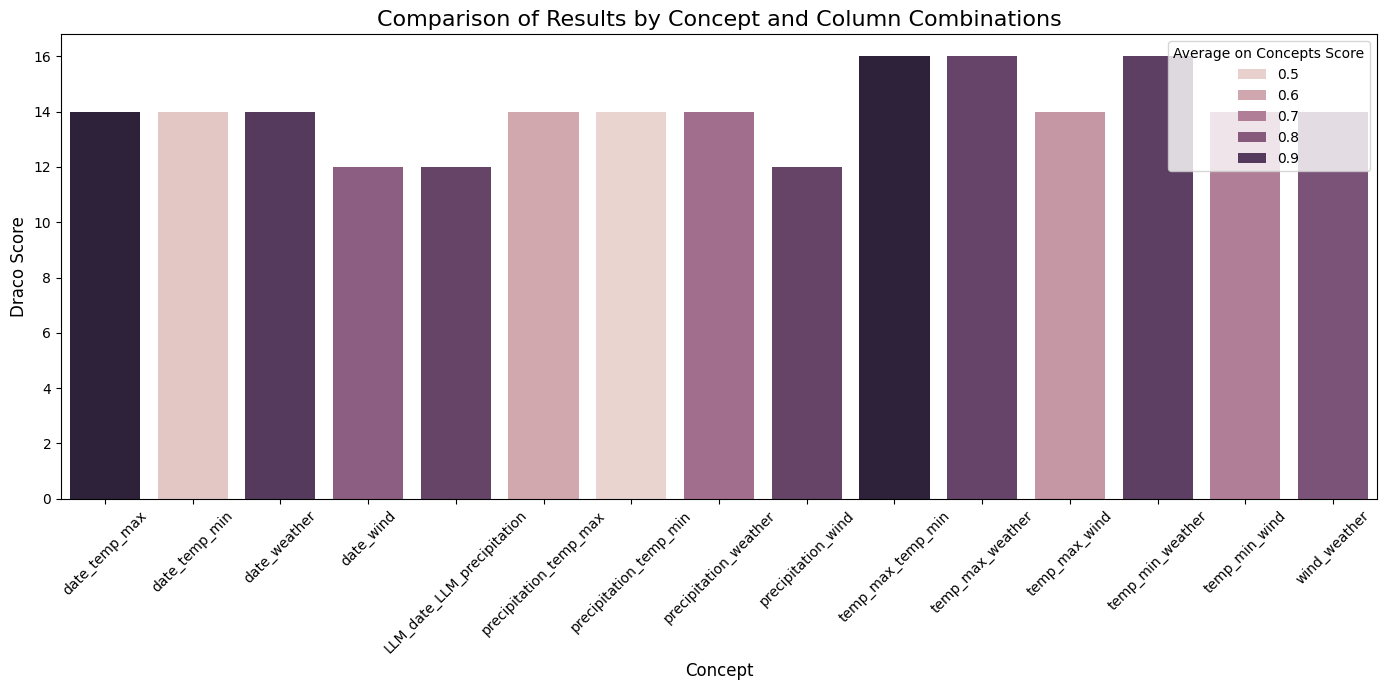

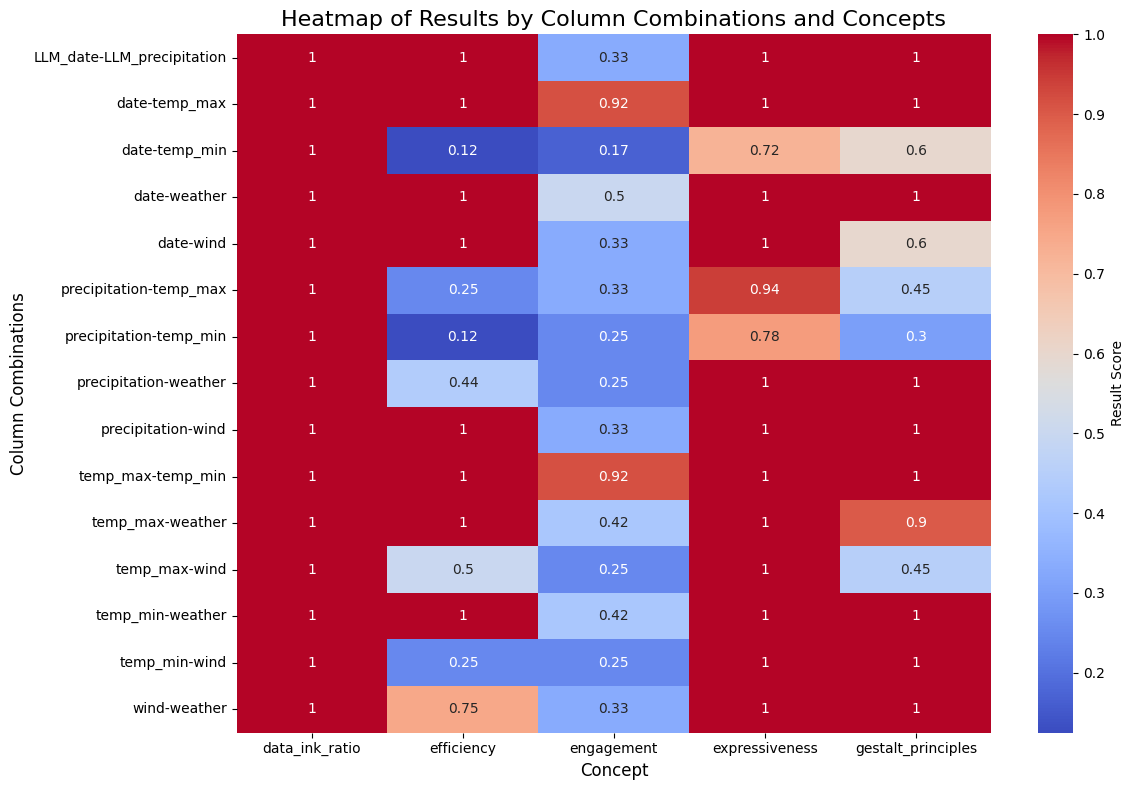

C:\Users\raudvee\AppData\Local\Temp\ipykernel_8804\813593582.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=top_results, x="concept", y="Result", hue="cols", dodge=False, ci=None)


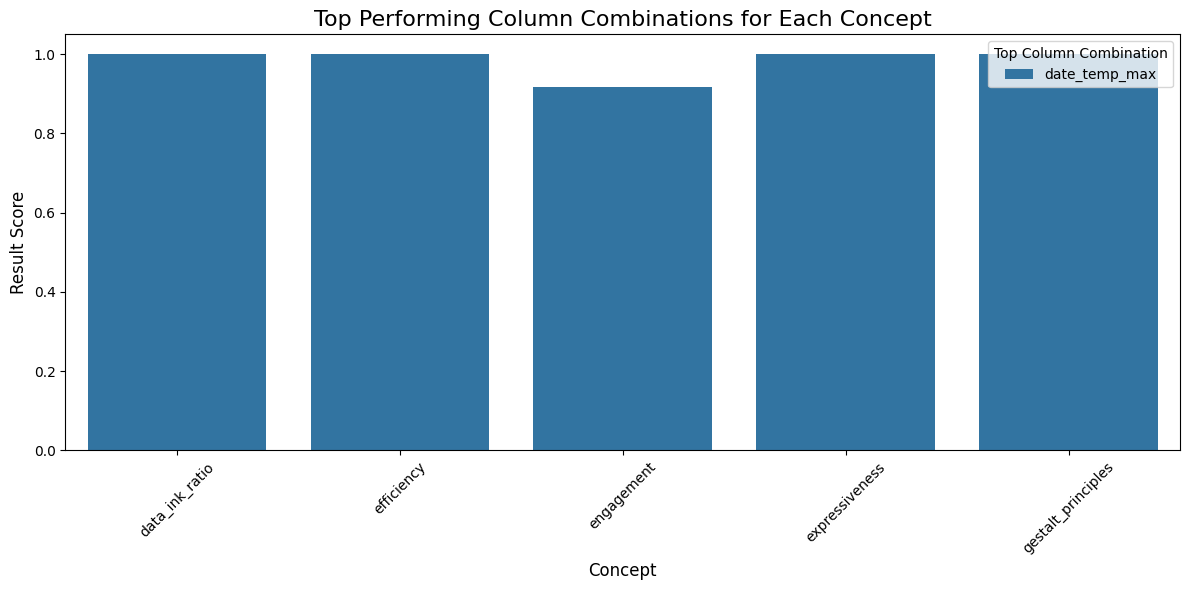

In [14]:
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_results = pd.read_csv("./results.csv")

# Convert the string representation of lists to actual lists
df_results['Result'] = df_results['Result'].apply(ast.literal_eval)
df_results['draco_score'] = df_results['draco_score'].apply(int)

# Calculate the average of the lists
df_results["Result"] = df_results['Result'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)

# Step 1: Create a grouped bar plot for each concept
df_results['cols'] = df_results['col1'] + '_' + df_results['col2']
df_results['average_result'] = df_results.groupby('cols')['Result'].transform('mean')
df_results.sort_values(by='draco_score', ascending=True)

plt.figure(figsize=(14, 7))
sns.barplot(data=df_results, x="cols", y="draco_score", hue='average_result', errorbar=None)
plt.title("Comparison of Results by Concept and Column Combinations", fontsize=16)
plt.ylabel("Draco Score", fontsize=12)
plt.xlabel("Concept", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Average on Concepts Score")
plt.tight_layout()
plt.show()

# Step 2: Create a heatmap to compare scores across all combinations and concepts
pivot_df = df_results.pivot_table(values="Result", index=["col1", "col2"], columns="concept")
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap="coolwarm", cbar_kws={'label': 'Result Score'})
plt.title("Heatmap of Results by Column Combinations and Concepts", fontsize=16)
plt.ylabel("Column Combinations", fontsize=12)
plt.xlabel("Concept", fontsize=12)
plt.tight_layout()
plt.show()

# Step 3: Highlight top-performing combinations for each concept
top_results = df_results.loc[df_results.groupby("concept")["Result"].idxmax()]
plt.figure(figsize=(12, 6))
sns.barplot(data=top_results, x="concept", y="Result", hue="cols", dodge=False, ci=None)
plt.title("Top Performing Column Combinations for Each Concept", fontsize=16)
plt.ylabel("Result Score", fontsize=12)
plt.xlabel("Concept", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Top Column Combination")
plt.tight_layout()
plt.show()

In [11]:
df_results['average_result'] = df_results.groupby('cols')['Result'].transform('mean')

df_results

col1      col2  draco_score             concept    Result           cols  \
0   date  temp_max           14      expressiveness  1.000000  date_temp_max   
1   date  temp_max           14          efficiency  1.000000  date_temp_max   
2   date  temp_max           14          engagement  0.916667  date_temp_max   
3   date  temp_max           14      data_ink_ratio  1.000000  date_temp_max   
4   date  temp_max           14  gestalt_principles  1.000000  date_temp_max   
..   ...       ...          ...                 ...       ...            ...   
70  wind   weather           14      expressiveness  1.000000   wind_weather   
71  wind   weather           14          efficiency  0.750000   wind_weather   
72  wind   weather           14          engagement  0.333333   wind_weather   
73  wind   weather           14      data_ink_ratio  1.000000   wind_weather   
74  wind   weather           14  gestalt_principles  1.000000   wind_weather   

    average_result  
0         0.983333  
1         0.983333  
2         0.983333  
3         0.983333  
4         0.983333  
..             ...  
70        0.816667  
71        0.816667  
72        0.816667  
73        0.816667  
74        0.816667  

[75 rows x 7 columns]

In [ ]:
prompt = """List a few popular cookie recipes in JSON format.

Use this JSON schema:

Recipe = {'recipe_name': str, 'ingredients': list[str]}
Return: list[Recipe]"""
result = model.generate_content(prompt)
print(result.text)

```json
[
  {
    "recipe_name": "Chocolate Chip Cookies",
    "ingredients": [
      "1 cup (2 sticks) unsalted butter, softened",
      "1 cup granulated sugar",
      "1 cup packed brown sugar",
      "2 teaspoons pure vanilla extract",
      "2 large eggs",
      "3 cups all-purpose flour",
      "1 teaspoon baking soda",
      "1 teaspoon salt",
      "2 cups chocolate chips"
    ]
  },
  {
    "recipe_name": "Oatmeal Raisin Cookies",
    "ingredients": [
      "1 cup (2 sticks) unsalted butter, softened",
      "1 cup granulated sugar",
      "1 cup packed brown sugar",
      "2 large eggs",
      "1 teaspoon vanilla extract",
      "3 cups rolled oats",
      "2 1/2 cups all-purpose flour",
      "1 teaspoon baking soda",
      "1 teaspoon ground cinnamon",
      "1/2 teaspoon salt",
      "1 cup raisins"
    ]
  },
  {
    "recipe_name": "Peanut Butter Cookies",
    "ingredients": [
      "1 cup peanut butter",
      "1 cup granulated sugar",
      "1 cup packed brown sugar",
 

In [ ]:
# What we can have from the coding side: 
# 1. vega-lite specification
# 2. facts about the data, including statistical
